### Results
> starting accuracy = 0.3438

> final accuracy = 0.8169

# Improvements 
- In chapter 6, it is noted that sigmoid and tanh use can lead to vanishing gradients in hidden layers(high input values lead to "saturated" outputs where derivative is close to 0). Therefore, ReLU may be a better option
- In the output layer we will continue to use softmax as it is a multiclass problem, we would use sigmoud if it was a binary problem.
- Standardising features achieved ~+1.0% accuracy
> learning_rate

    - 0.01 = 40%
    - 0.05 = 40%
    - 0.1 = 37%
    - 0.5 = 33%

- updated `get_features_text()`
    - Previously I had been using fit_transform on the get_features() implementation for train and test. Although you only want to initialise a new tfidf vectoriser once (for the train) and then for the test, you need to feed in the same vectoriser used for the train data, this is to ensure that both the train and test use the same vocabularly. Otherwise, the same word might map to different feature indices (or not exist at all) between train and test, causing the model to receive misaligned inputs at test time
- Increasing the size of the hidden layers had a huge benefit, the original setup had 64,32 givign about 50% but with 128,128 I get 69% accuracy
- 256,128 layout for the hidden layers brought the accuracy up to 81% where I stopped.

### Library Imports

In [372]:
%matplotlib inline
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.datasets import make_classification
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.feature_extraction.text import TfidfVectorizer
from IPython.display import clear_output
seed = 42
np.random.seed(seed)

### Class initialisation

To recap from the lecture, creating a feedforward neural network and training it involves the following steps:

1. **Initialise Layers:**
   - For each layer, initialise a weight matrix and a bias vector:
      - The weight matrix (**W**) size is (input features size, output features size).
      - The bias vector (**b**) size is (1, output features size).

2. **Define Activation Functions for Hidden Layers:**
   - Choose activation functions for hidden layers. Common choices include:
      - [Sigmoid](https://en.wikipedia.org/wiki/Sigmoid_function)
      - [Softmax](https://en.wikipedia.org/wiki/Softmax_function)
      - [ReLU](https://en.wikipedia.org/wiki/Rectifier_(neural_networks)

3. **Define Forward Propagation Function:**
   - Implement a function that computes the output of the neural network given an input by applying activation functions to the weighted sums of inputs at each layer.

4. **Define Loss Function:**
   - Choose a loss function that measures the distance between predicted and gold outputs. Common choices include mean squared error for regression tasks and cross-entropy loss for classification tasks.

5. **Define Backward Propagation Function:**
   - Implement a function that computes the gradients of the loss with respect to the weights and biases by applying the chain rule of calculus.

6. **Define Training Loop:**
   - Iterate through the training data multiple times, performing the following in each iteration:
      - Forward pass to compute predictions.
      - Compute loss using the chosen loss function.
      - Backward pass to compute gradients.
      - Update weights and biases using an optimisation algorithm (e.g., gradient descent).
      - Repeat until the loss converges or a predefined number of iterations are reached.

It's good practice to implement neural network architectures using the class data structure in Python for reusability. This allows training multiple instances with different hyperparameters and facilitates debugging in case of issues. Following this practice, below we implement our feedforward neural network as a class, incorporating the steps above.

In [373]:
class FeedforwardNeuralNetwork:
    # Step 1: Initialise weights and biases
    def __init__(self, input_size: int, hidden_size1: int, hidden_size2: int, output_size: int) -> None:
        '''
        Initialises the neural network with random weights and zero biases.

        Args:
          input_size (int): Number of features in the input data.
          hidden_size1 (int): Number of neurons in the first hidden layer.
          hidden_size2 (int): Number of neurons in the second hidden layer.
          output_size (int): Number of classes in the output layer.
        '''

        # Layer 1
        # Layer 1 weights matrix: (input_size, hidden_size1)
        self.W1 = np.random.randn(input_size, hidden_size1)
        print("Weights layer 1 shape:", self.W1.shape) # -> (1500, 64)
        self.b1 = np.zeros((1, hidden_size1))

        # Layer 2
        # Layer 2 weights matrix: (hidden_size1, hidden_size2)
        self.W2 = np.random.randn(hidden_size1, hidden_size2)
        print("Weights layer 2 shape:", self.W2.shape) # -> (64, 32)
        self.b2 = np.zeros((1, hidden_size2))

        # Layer 3 (Output layer)
        # Layer 3 weights matrix: (hidden_size2, output_size)
        self.W3 = np.random.randn(hidden_size2, output_size)
        print("Weights layer 3 shape:", self.W3.shape) # -> (32, 3)
        self.b3 = np.zeros((1, output_size))


    # Step 2: Activation Functions
    # 2.1: activation functions
    def sigmoid(self, z: np.ndarray) -> np.ndarray:
        """
          Sigmoid function that gives us the predictions of the given samples.

          Args:
              Z (array): each row contains z = b + w_1 x_1 + w_2 x_2 + ... + w_n x_n

          Returns:
              np.ndarray: array containing a prediction for each sample.
        """
        return 1 / (1 + np.exp(-z))
    
    def reLU(self, z:np.ndarray) -> np.ndarray:
      '''
      np.maximum checks each value in Z and compares it against 0, would not work with max
      ''' 
      return np.maximum(0, z)

    def softmax(self, z: np.ndarray) -> np.ndarray:
        """
          Softmax function that gives us the predictions of the given samples.

          Args:
              Z (array): each row contains z = b + w_1 x_1 + w_2 x_2 + ... + w_n x_n

          Returns:
              np.ndarray: array containing a prediction for each sample.
        """
        exp_z = np.exp(z - np.max(z, axis=1, keepdims=True))
        return exp_z / np.sum(exp_z, axis=1, keepdims=True)

    # 2.2: derivatives of activation functions
    def d_sigmoid(self, x: np.ndarray) -> np.ndarray:
      return x * (1 - x)
    
    def d_reLU(self, z: np.ndarray) -> np.ndarray:
    # z >= 0 checks if each element of z is greater than 0, if true, astype(float), converts it to 1, false = 0
      return (z >= 0).astype(float)

    # Step 3: Perform Forward propagation
    def forward(self, X: np.ndarray, epoch: int=0) -> np.ndarray:
        '''
        Performs forward propagation for the neural network.

        Args:
            X (numpy.ndarray): Input data with dimensions (num_samples, num_features).

        Returns:
            numpy.ndarray: Output predictions after passing through the network's layers.
        '''

        ## INSERT YOUR CODE HERE ##
        # Layer 1
        # Compute Z for Layer 1 using input data and Layer 1 weights
        # X: (num_train_samples, num_features) x weights layer 1: (input_size, hidden_size1) -> Z1: (num_train_samples, hidden_size1)
        Z1 = np.dot(X, self.W1) + self.b1

        # Compute the output of Layer 1 using the activation function of Layer 1 and Layer 1 Z
        # Z1: (num_train_samples, hidden_size1) -> a1: (num_train_samples, hidden_size1)
        self.a1 = self.reLU(Z1)

        if epoch == 0:
          print("Z1 shape (num_train_samples, hidden_size1):", Z1.shape)  # -> (4500, 64)
          print("a1 shape (num_train_samples, hidden_size1):", self.a1.shape)  # -> (4500, 64)


        # Layer 2

        # Compute Z for Layer 2 using output of Layer 1 and Layer 2 weights
        # a1: (num_train_samples, hidden_size1) x weights layer 2: (hidden_size1, hidden_size2) -> Z2: (num_train_samples, hidden_size2)
        Z2 = np.dot(self.a1, self.W2) + self.b2

        # Compute the output of Layer 2 using the activation function of Layer 2 and Layer 2 Z
        # Z2: (num_train_samples, hidden_size2) -> a2: (num_train_samples, hidden_size2)
        self.a2 = self.reLU(Z2)

        if epoch == 0:
          print("Z2 shape (num_train_samples, hidden_size2):", Z2.shape)  # -> (4500, 32)
          print("a2 shape (num_train_samples, hidden_size2):", self.a2.shape)  # -> (4500, 32)


        # Layer 3 (Output Layer)

        # Compute Z for Layer 3 using output of Layer 2 and Layer 3 weights
        # a2: (num_train_samples, hidden_size2) x weights layer 3: (hidden_size2, output_size) -> Z3: (num_train_samples, output_size)
        Z3 = np.dot(self.a2, self.W3) + self.b3

        # Compute the output of Layer 3 (output of the network) using the activation function of Layer 3 and Layer 3 Z
        # Z3: (num_train_samples, output_size) -> a3: (num_train_samples, output_size)
        self.a3 = self.softmax(Z3)

        if epoch == 0:
          print("Z3 shape (num_train_samples, output_size):", Z3.shape)  # -> (4500, 3)
          print("a3 shape (num_train_samples, output_size):", self.a3.shape)  # -> (4500, 3)

        ## END OF YOUR CODE ##

        return self.a3


    # Step 4: Cross-Entropy Loss Calculation
    def cross_entropy_loss(self, y_true: np.ndarray, y_pred: np.ndarray) -> float:
        '''
        Computes the cross-entropy loss between the true labels and predicted probabilities.

        Args:
          y_true (numpy.ndarray): True class labels with dimensions (num_samples,).
          y_pred (numpy.ndarray): Predicted probabilities with dimensions (num_samples, num_classes).

        Returns:
          float: Cross-entropy loss.
        '''
        num_samples = len(y_true)
        loss = -np.sum(np.log(y_pred[np.arange(num_samples), y_true])) / num_samples
        return loss


    # Step 6: Perform Backward propagation
    def backward(self, X: np.ndarray, y_true: np.ndarray, learning_rate: float=0.01, epoch: int=1) -> None:
        '''
        Computes the cross-entropy loss between the true labels and predicted probabilities.

        Args:
          X (numpy.ndarray): Samples in the dataset.
          y_true (numpy.ndarray): True class labels with dimensions (num_samples,).
          learning_rate (float): Learning rate used to update weights. Deafulto to 0.01.
          epoch (int): current epoch during training, used to print matrix weights only for first epoch. Default to 1.
        '''

        num_samples = len(X)

        # 5.1 Compute Gradients for Layer 3 (Output Layer) (d_a3, d_W3, d_b3):
        '''
        d_a3: Calculate the error at the output layer by subtracting 1
         from the predicted probabilities corresponding to the true class.

        d_W3: Compute the gradient of the loss with respect to the weights connecting
         the third layer (output layer) to the second layer.

        d_b3: Compute the gradient of the loss with respect to the biases of the output layer.
        '''
        d_a3 = self.a3.copy()
        d_a3[np.arange(num_samples), y_true] -= 1
        d_L3 = d_a3/ num_samples

        d_W3 = np.dot(self.a2.T, d_L3)
        d_b3 = np.sum(d_L3, axis=0, keepdims=True)
        if epoch == 0:
          print("d_a3 shape (num_train_samples, output_size):", d_a3.shape)  # -> (4500, 3)
          print("d_L3 shape (num_train_samples, output_size):", d_L3.shape)  # -> (4500, 3)
          print("d_W3 shape (hidden_size2, output_size):", d_W3.shape)  # -> (32, 3)
          print("d_b3 shape (1, output_size):", d_b3.shape)  # -> (1, 3)

        # 5.2 Compute Gradients for Layer 2 (d_a2, d_W2, d_b2):
        '''
        d_a2: Calculate the error at the hidden layer .

        d_W2: Compute the gradient of the layer 3 output with respect to the weights connecting
         the second layer (hidden layer) to the first layer (input layer).

        d_b2: Compute the gradient of the layer 3 output with respect to the biases of the hidden layer.
        '''
        d_a2 = np.dot(d_L3, self.W3.T)
        d_L2 = d_a2 * (self.d_reLU(self.a2))

        d_W2 = np.dot(self.a1.T, d_L2)
        d_b2 = np.sum(d_L2, axis=0, keepdims=True)
        if epoch == 0:
          print("d_a2 shape (num_train_samples, hidden_size2):", d_a2.shape)  # -> (4500, 32)
          print("d_L2 shape (num_train_samples, hidden_size2):", d_L2.shape)  # -> (4500, 32)
          print("d_W2 shape (hidden_size1, hidden_size2):", d_W2.shape)  # -> (64, 32)
          print("d_b2 shape (1, hidden_size2):", d_b2.shape)  # -> (1, 32)

        # 5.3 Compute Gradients for Layer 1 (d_a1, d_W1, d_b1):
        d_a1 = np.dot(d_L2, self.W2.T)
        d_L1 = d_a1 * (self.d_reLU(self.a1))

        d_W1 = np.dot(X.T, d_L1)
        d_b1 = np.sum(d_L1, axis=0, keepdims=True)
        if epoch == 0:
          print("d_a1 shape (num_train_samples, hidden_size1):", d_a1.shape)  # -> (4500, 64)
          print("d_L1 shape (num_train_samples, hidden_size1):", d_L1.shape)  # -> (4500, 64)
          print("d_W1 shape (input_size, hidden_size2):", d_W1.shape)  # -> (1500, 64)
          print("d_b1 shape (1, input_size):", d_b1.shape)  # -> (1, 64)

        # 5.4 Update weights and biases
        self.W1 -= learning_rate * d_W1
        self.b1 -= learning_rate * d_b1
        self.W2 -= learning_rate * d_W2
        self.b2 -= learning_rate * d_b2
        self.W3 -= learning_rate * d_W3
        self.b3 -= learning_rate * d_b3

    # Step 6: Training Loop
    def train(self, X: np.ndarray, y_true: np.ndarray, epochs: int=100, learning_rate: float=0.01) -> None:
        '''
        Trains the neural network using the specified training data.

        Args:
            X (numpy.ndarray): Input data with dimensions (num_samples, num_features).
            y_true (numpy.ndarray): True class labels with dimensions (num_samples,).
            epochs (int): Number of training epochs. Default to 100.
            learning_rate (float): Learning rate for weight updates. Default to 0.01.
        '''
        self.losses = []

        # tqdm is a function that given a list, the total number of iterations and a description,
        # returns a progressbar showing the time execution
        # pbar will be updated to include the loss at each epoch
        pbar = tqdm(range(epochs), total=epochs, desc="Training")
        for epoch in pbar:
              # 6.1 Forward pass
              y_pred = self.forward(X, epoch)

              # 6.2 Compute loss
              loss = self.cross_entropy_loss(y_true, y_pred)
              self.losses.append(loss)
              # updated the progressbar to include the loss of this epoch
              pbar.set_description(f'Training - Epoch {epoch + 1}/{epochs}, Loss: {loss:0.03f}') #0.03f to display the first decimal points

              # 6.3 Backward pass
              self.backward(X, y_true, learning_rate, epoch)


    def show_learning_curve(self) -> None:
        '''
        Displays the learning curve (loss curve) during training.
        '''
        plt.plot(self.losses)
        plt.xlabel('Epochs') # x axis label
        plt.ylabel('Cross-Entropy Loss') # y axis label
        plt.show()


    def test(self, X: np.ndarray) -> np.ndarray:
        '''
        Calculates the predictions for the given samples.

        Args:
            X (numpy.ndarray): Input data with dimensions (num_samples, num_features).

        Returns:
            numpy.ndarray: Output predictions after passing through the network's layers.
        '''
        y_pred = self.forward(X)
        return y_pred

In [374]:
# !wget --no-check-certificate 'https://docs.google.com/uc?export=download&id=1QfAUt0u4wLZVy2Ta1G90jOLNaqzAw2eW' -O agnews_test.csv
# !wget --no-check-certificate 'https://docs.google.com/uc?export=download&id=1UsOBTnfch-Su4kqmkzXcIizwJt6NWtXZ' -O agnews_train.csv
# clear_output()

In [375]:
import pandas as pd

# labels contained in the dataset
labels = ['sports', 'business', 'science']
df = pd.read_csv('agnews_train.csv', header=None)

# in the dataset gold labels are given as: 1 (World), 2 (Sports), 3 (Business), 4 (Science/Technology)
# we discard all the rows with gold label 1 (World) and we keep all the other rows
df = df[df[0] != 1]
df['label'] = df[0]-2

# we concatenate title and body to obtain a unified text
df['text'] = [" ".join((title, body)) for title, body in zip(df[1], df[2])]
processed_df = df.drop(columns=[0,1,2])
processed_df.head(10)

# Split data
X_train, _, y_train, _ = train_test_split(processed_df['text'], processed_df['label'], test_size=0.5, random_state=seed, stratify=processed_df['label'])

Shape of train dataset after computing TD-IDF features for each text: (45000, 1500)
Weights layer 1 shape: (1500, 256)
Weights layer 2 shape: (256, 128)
Weights layer 3 shape: (128, 3)


Training:   0%|          | 0/200 [00:00<?, ?it/s]/var/folders/wz/ggvm7p353k760lj9f743dp0m0000gn/T/ipykernel_52362/1399927519.py:148: RuntimeWarning: divide by zero encountered in log
  loss = -np.sum(np.log(y_pred[np.arange(num_samples), y_true])) / num_samples
Training - Epoch 1/200, Loss: inf:   0%|          | 1/200 [00:00<00:37,  5.28it/s]

Z1 shape (num_train_samples, hidden_size1): (45000, 256)
a1 shape (num_train_samples, hidden_size1): (45000, 256)
Z2 shape (num_train_samples, hidden_size2): (45000, 128)
a2 shape (num_train_samples, hidden_size2): (45000, 128)
Z3 shape (num_train_samples, output_size): (45000, 3)
a3 shape (num_train_samples, output_size): (45000, 3)
d_a3 shape (num_train_samples, output_size): (45000, 3)
d_L3 shape (num_train_samples, output_size): (45000, 3)
d_W3 shape (hidden_size2, output_size): (128, 3)
d_b3 shape (1, output_size): (1, 3)
d_a2 shape (num_train_samples, hidden_size2): (45000, 128)
d_L2 shape (num_train_samples, hidden_size2): (45000, 128)
d_W2 shape (hidden_size1, hidden_size2): (256, 128)
d_b2 shape (1, hidden_size2): (1, 128)
d_a1 shape (num_train_samples, hidden_size1): (45000, 256)
d_L1 shape (num_train_samples, hidden_size1): (45000, 256)
d_W1 shape (input_size, hidden_size2): (1500, 256)
d_b1 shape (1, input_size): (1, 256)


Training - Epoch 200/200, Loss: inf: 100%|██████████| 200/200 [00:33<00:00,  5.90it/s]


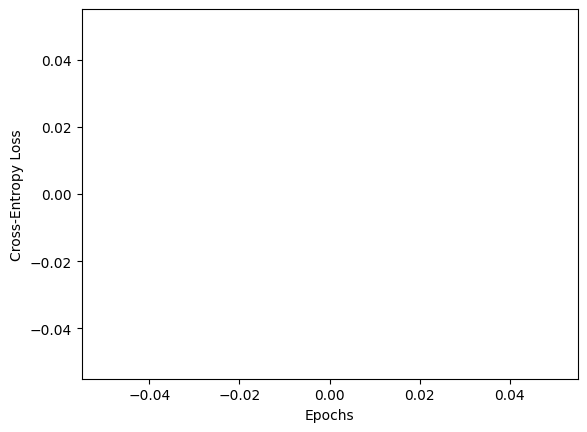

In [376]:
# construct a new feature matrix containing the features calculated using TD-IDF
# Create TF-IDF features

## INSERT YOUR CODE HERE ##
from sklearn.feature_extraction.text import TfidfVectorizer

def get_features_text(text: pd.Series, max_features: int, vectoriser=None):
    """
    Calculate text features for the given text using TF-IDF with the given maximum number of features.

    Args:
        text (pd.Series): a column of texts in a pandas dataframe.
        max_features (int): TF-IDF vectoriser instance.

    Returns:
        Matrix: TF-IDF Features extracted from the text.
    
    If vectoriser is None, create and fit a new one (training).
    Otherwise, use the provided vectoriser (testing).
    """
    if vectoriser is None:
        # Training: create new vectorizer and fit_transform
        vectoriser = TfidfVectorizer(max_features=max_features)
        tfidf_features_matrix = vectoriser.fit_transform(text)
        return tfidf_features_matrix, vectoriser
    else:
        # Testing: use existing vectorizer, transform only
        tfidf_features_matrix = vectoriser.transform(text)
        return tfidf_features_matrix

## END OF YOUR CODE ##

max_features = 1500  # Adjust max_features as needed
train_TD_IDF_features, tfidf_vectoriser = get_features_text(X_train, max_features)


# TfidfVectorizer returns a sparse matrix, we need to convert this matrix into a numpy array to pass it trough our Neural Network
# the todense() function allows us to convert the dense matrix into a list that we convert to a numpy array using np.array()
X_train = np.array(train_TD_IDF_features.todense())
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)

print(f"Shape of train dataset after computing TD-IDF features for each text: {train_TD_IDF_features.shape}")
# -> (4500, 1500)

# Hyperparameters definition
input_size = X_train.shape[1]
hidden_size1 = 256
hidden_size2 = 128
output_size = np.max(y_train) + 1  # Assuming class labels are 0, 1, 2, ...

learning_rate = 0.01
epochs = 200

## INSERT YOUR CODE HERE ##

# Instantiate the network with the correct layer sizes
model = FeedforwardNeuralNetwork(input_size, hidden_size1, hidden_size2, output_size)

# Execute a forward step to check your code
# predictions = model.forward(X)

# Train the model

model.train(X_train, y_train, epochs, learning_rate)
model.show_learning_curve()

## END OF YOUR CODE ##



### Evaluation

In [377]:
# Preprocess the test set to set it in the correct format, i.e.
# create y_test containing the labels and X_test containing text features created using TF-IDF.
# For computation purposes, we restrict the test to 5% of its original size.
# This cell repeats some steps from Section 2.1 to obtain the restricted test set

df = pd.read_csv('agnews_test.csv', header=None)
df = df[df[0] != 1]
df['label'] = df[0]-2

df['text'] = [" ".join((title, body)) for title, body in zip(df[1], df[2])]
processed_df = df.drop(columns=[0,1,2])
processed_df.head(10)

_, X_test, _, y_test = train_test_split(processed_df['text'], processed_df['label'], test_size=0.99, random_state=seed, stratify=processed_df['label'])


test_TD_IDF_features = get_features_text(X_test, max_features, vectoriser=tfidf_vectoriser)

X_test = np.array(test_TD_IDF_features.todense())

X_test = scaler.transform(X_test)

print(f"Shape of test dataset after computing TD-IDF features for each text: {test_TD_IDF_features.shape}")
# -> (285, 1500)

print(X_test.shape)

# Making predictions on the test set using the trained weights
test_predictions = model.test(X_test)

# select the class with the highest probability
multiclass_predictions = np.argmax(test_predictions, axis=1)

# Evaluating the model using Accuracy (as seen in Week 1 Lab)
accuracy = accuracy_score(y_test, multiclass_predictions)
print(f"Accuracy: {accuracy}")

Shape of test dataset after computing TD-IDF features for each text: (5643, 1500)
(5643, 1500)
Z1 shape (num_train_samples, hidden_size1): (5643, 256)
a1 shape (num_train_samples, hidden_size1): (5643, 256)
Z2 shape (num_train_samples, hidden_size2): (5643, 128)
a2 shape (num_train_samples, hidden_size2): (5643, 128)
Z3 shape (num_train_samples, output_size): (5643, 3)
a3 shape (num_train_samples, output_size): (5643, 3)
Accuracy: 0.8169413432571327
